# PCA followed by t-SNE

Morgan Fingerprints obtained as bit vectors in part 1 were used in this notebook for chemical space visualization. First, an unsupervised machine learning algorithm known as Principal Component Analysis(PCA) was utilized to obtain a new set of dimensions to represent the data. These new dimensions are known as 'principal components'. These components were then used to create a 2D visualization of the chemical space with t-SNE(t-distributed stochastic neighbor embedding).

In [1]:
'''
Unlike tensorflow, scikit-learn modules auch as PCA and t-SNE do not automatically utilize GPUs. As our data is quite large,
we will be using modules in the cuML and cudf library to import PCA and t-SNE. cuML has many scikit-learn like modules and
directly utilizes GPU if present whereas cuDF is similar to pandas.
'''

from cuml.decomposition import PCA

import os
import pandas as pd

import cudf
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# provide path to fingerprint data
# 'drd2_cluster_fingerprints.csv' is not provided in this repo due to large file size

data_path = 'fingerprints/drd2_cluster_fingerprints.csv'

In [3]:
df = cudf.read_csv(data_path)

In [4]:
df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 176454 entries, 0 to 176453
Columns: 2049 entries, Dataset to 2047
dtypes: bool(2048), object(1)
memory usage: 346.5+ MB


In [5]:
df = df.reset_index(drop = True)
df.tail()

,Dataset,0,1,2,3,4,5,6,7,8,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
176449,chembl,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
176450,chembl,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
176451,chembl,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
176452,chembl,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
176453,chembl,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [6]:
# check for null values
df.isnull().sum().sum()

0

In [7]:
df.groupby(['Dataset']).count()

'''
Here we have fingerprint data orbtained from 4 different datasets.

1. ChEMBL dataset
2. DRD2 trainign data used to train the socring agent for both REINVENT and ReLeaSE's Reinforcement Learning(RL) systems.
3. Data generated by REINVENT's RL system for DRD2.
4. Data generated by ReLeaSE's RL system for DRD2.
'''

"\nHere we have fingerprint data orbtained from 4 different datasets.\n\n1. ChEMBL dataset\n2. DRD2 trainign data used to train the socring agent for both REINVENT and ReLeaSE's Reinforcement Learning(RL) systems.\n3. Data generated by REINVENT's RL system for DRD2.\n4. Data generated by ReLeaSE's RL system for DRD2.\n"

In [8]:
# Use label encoder to conver staring labels in to numeric labels

from cuml.preprocessing import LabelEncoder

le = LabelEncoder()

In [9]:
dataset_name = le.fit_transform(df['Dataset'])
df['Dataset_n'] = dataset_name

In [10]:
le.inverse_transform(cudf.Series([0, 1, 2, 3]))

# labels     Dataset

0      DRD2_training
1    REINVENT_filter
2            ReLeaSE
3             chembl
dtype: object

In [11]:
df.head()

,Dataset,0,1,2,3,4,5,6,7,8,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,Dataset_n
0,REINVENT_filter,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,1
1,REINVENT_filter,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,1
2,REINVENT_filter,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3,REINVENT_filter,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,1
4,REINVENT_filter,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,1


In [12]:
dataset_df = df['Dataset_n'].to_pandas()

In [13]:
dataset_df

0         1
1         1
2         1
3         1
4         1
         ..
176449    3
176450    3
176451    3
176452    3
176453    3
Name: Dataset_n, Length: 176454, dtype: uint8

In [15]:
# create a new dataframe with only the fingerprints for PCA and t-SNE
fps_df = df.drop(['Dataset','Dataset_n'], axis = 1)
fps_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [16]:
# convert df into a list
fps_list = fps_df.values.tolist()

In [17]:
# the length should be equal to number of indices
len(fps_list)

176454

In [18]:
# check shape for the number of attributes
(np.array(fps_list)).shape

(176454, 2048)

In [19]:
fps_arr = np.asarray(fps_list, dtype = np.float32)

## Use cuML for Principal Component Analysis(PCA)

In [20]:
from cuml.decomposition import PCA
from tqdm import tqdm

In [27]:
# this function calculates the amount of data variation explained by a certain number of components
# we want the least number of components that expalin most variation in the data
# for our data we have 2048 dimensions so we will check the variation explained by up to 500 components

def get_component_performance(fps_arr):
    result = []
    for n in tqdm(range(2,502)):
        pca = PCA(n_components = n)
        cmpts = pca.fit_transform(fps_arr)
        variance = np.sum(pca.explained_variance_ratio_)
        result.append([n, variance])
    return result

In [28]:
all_results = get_component_performance(fps_arr)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [08:13<00:00,  1.01it/s]


In [29]:
all_results_df = pd.DataFrame(all_results, columns = ['Components','Variance'])

In [30]:
all_results_df.tail()

,Components,Variance
495,497,0.737741
496,498,0.738120
497,499,0.738498
498,500,0.738875
499,501,0.739252


In [31]:
dataset_df.tail()

176449    3
176450    3
176451    3
176452    3
176453    3
Name: Dataset_n, dtype: uint8

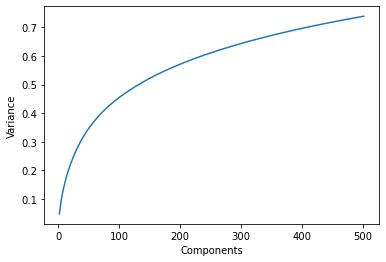

In [32]:
ax = sns.lineplot(data = all_results_df, x = 'Components', y = 'Variance')

'''
here we can see that 500 components explain roughly 70% of the variation in our data which is decent given 
the amount of data and the number of attributes/dimensions.
'''

In [33]:
# wel will use a total of 500 components
pca = PCA(n_components = 500)

# fit and transform the data
cmpts = pca.fit_transform(fps_arr)

# 2D Visualization using t-SNE

Although our data still have a high number of components, we can use t-SNE to visualize this data in 2D.

In [34]:
from cuml.manifold import TSNE
%time cmpts_embedded = TSNE(n_components = 2, perplexity = 45).fit_transform(cmpts)

[W] [12:06:42.274671] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 6.73 s, sys: 4.44 s, total: 11.2 s
Wall time: 11.1 s


In [35]:
tsne_df = pd.DataFrame(cmpts_embedded, columns = ['tsne_x','tsne_y'])
tsne_df['Dataset_n'] = dataset_df

In [36]:
tsne_df.head()

,tsne_x,tsne_y,Dataset_n
0,-10.581294,82.610451,1
1,-16.601986,85.670937,1
2,-10.492631,82.390060,1
3,-15.834785,43.093731,1
4,-9.382377,81.404320,1


In [37]:
tsne_df.groupby(['Dataset_n']).count()

,tsne_x,tsne_y
Dataset_n,,
0,8359,8359
1,9050,9050
2,9048,9048
3,149997,149997


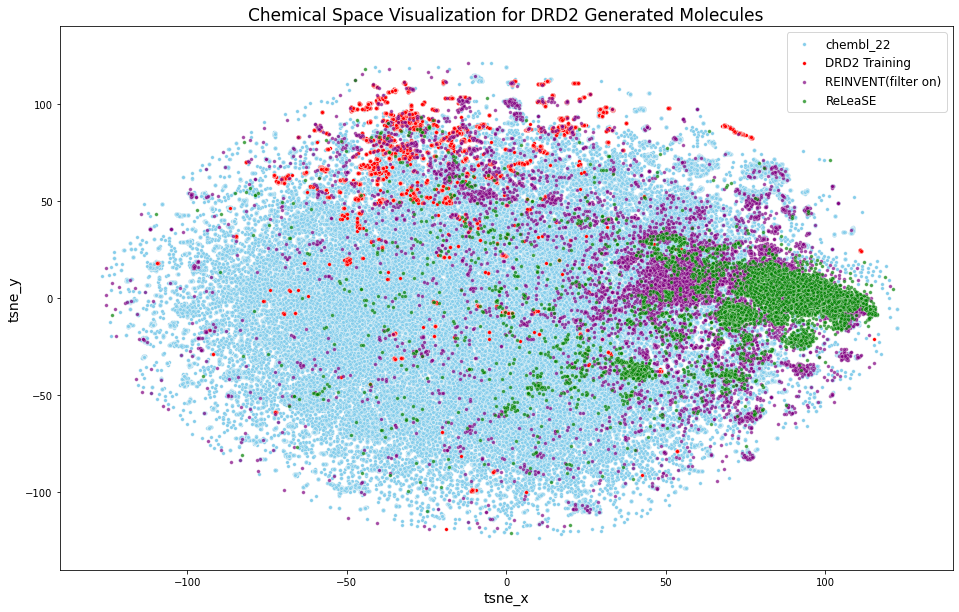

In [39]:
# create scatter plot

plt.figure(figsize = (16,10))

ax = sns.scatterplot(data = tsne_df[tsne_df['Dataset_n'] == 3], x = 'tsne_x', y = 'tsne_y', color = 'skyblue', s = 13)
ax = sns.scatterplot(data = tsne_df[tsne_df['Dataset_n'] == 0], x = 'tsne_x', y = 'tsne_y', color = 'red', s = 13)
ax = sns.scatterplot(data = tsne_df[tsne_df['Dataset_n'] == 1], x = 'tsne_x', y = 'tsne_y', color = 'purple', s = 13, alpha = 0.7)
ax = sns.scatterplot(data = tsne_df[tsne_df['Dataset_n'] == 2], x = 'tsne_x', y = 'tsne_y', color = 'green', s = 13, alpha = 0.7)

_ = plt.legend(labels = ['chembl_22','DRD2 Training','REINVENT(filter on)','ReLeaSE'], prop = {'size': 12} )
plt.title('Chemical Space Visualization for DRD2 Generated Molecules', fontdict = {'fontsize': 17})
plt.xlabel('tsne_x',fontdict = {'fontsize': 14})
plt.ylabel('tsne_y',fontdict = {'fontsize': 14})
plt.xlim(-140, 140)
plt.ylim(-140, 140)
plt.savefig('images/DRD2_chemical_space.png')

In [40]:
'''
In the above scatter diagram, you can see how the datapoints in green and purple in highly clustered towards 
the left. In the next notebook (Pt.3) we will use 2D histograms to calculated the amount of data present in various
regions of this chemical space.
'''

'\nIn the above scatter diagram, you can see how the datapoints in green and purple in highly clustered towards \nthe left. In the next notebook (Pt.3) we will use 2D histograms to calculated the amount of data present in various\nregions of this chemical space.\n'